# **RBM**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.W = np.random.randn(num_visible, num_hidden) * 0.1
        self.b = np.zeros(num_hidden)
        self.a = np.zeros(num_visible)

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def gibbs_sampling(self, v, k):
        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v, self.W) + self.b)
            h_sample = np.random.binomial(1, h_prob)
            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.a)
            v = np.random.binomial(1, v_prob)
        return v, h_sample

    def compute_reconstruction_error(self, data):
      reconstructed_data = self.sigmoid(np.dot(self.sigmoid(np.dot(data, self.W) + self.b), self.W.T) + self.a)
      error = np.mean(np.sum(np.square(data - reconstructed_data), axis=1))
      return error

    def train(self, data, learning_rate, k, epochs, batch_size):
        num_batches = len(data) // batch_size
        costs = []

        for epoch in range(epochs):
            np.random.shuffle(data)
            for batch_idx in range(num_batches):
                batch_data = data[batch_idx * batch_size : (batch_idx + 1) * batch_size]

                v_0 = batch_data
                h_0_prob = self.sigmoid(np.dot(v_0, self.W) + self.b)
                h_0 = np.random.binomial(1, h_0_prob)

                v_k, h_k = self.gibbs_sampling(v_0, k)

                h_k_prob = self.sigmoid(np.dot(v_k, self.W) + self.b)

                pos_associations = np.dot(v_0.T, h_0_prob)
                neg_associations = np.dot(v_k.T, h_k_prob)

                self.W += learning_rate * (pos_associations - neg_associations) / batch_size
                self.a += learning_rate * np.mean(v_0 - v_k, axis=0)
                self.b += learning_rate * np.mean(h_0_prob - h_k_prob, axis=0)

            cost = self.compute_reconstruction_error(data)
            costs.append(cost)
            print(f'Epoch: {epoch+1}, Reconstruction Error: {cost}')
        return costs

    def reconstruct(self, v):
        h = self.sigmoid(np.dot(v, self.W) + self.b)
        v_reconstructed = self.sigmoid(np.dot(h, self.W.T) + self.a)
        return v_reconstructed

    def plot_receptive_fields(self, shape):
        fig, axes = plt.subplots(int(np.sqrt(self.num_hidden)), int(np.sqrt(self.num_hidden)), figsize=(10, 10))
        fig.suptitle('Receptive Fields of Hidden Units')
        for i, ax in enumerate(axes.flat):
            if i < self.num_hidden:
                ax.imshow(self.W[:, i].reshape(shape), cmap='gray')
                ax.axis('off')
        plt.show()




Epoch: 1, Reconstruction Error: 20.133471202497727
Epoch: 2, Reconstruction Error: 17.70488329570448
Epoch: 3, Reconstruction Error: 16.59790023679771
Epoch: 4, Reconstruction Error: 15.886478262161331
Epoch: 5, Reconstruction Error: 15.410350366262104
Epoch: 6, Reconstruction Error: 15.012328368477803
Epoch: 7, Reconstruction Error: 14.652745153034086
Epoch: 8, Reconstruction Error: 14.36541303607336
Epoch: 9, Reconstruction Error: 14.111327428058331
Epoch: 10, Reconstruction Error: 13.931361821691493
Epoch: 11, Reconstruction Error: 13.805932195814158
Epoch: 12, Reconstruction Error: 13.681637968691817
Epoch: 13, Reconstruction Error: 13.547414492135093
Epoch: 14, Reconstruction Error: 13.449332981492887
Epoch: 15, Reconstruction Error: 13.38422889410359
Epoch: 16, Reconstruction Error: 13.311632478216032
Epoch: 17, Reconstruction Error: 13.232695208048632
Epoch: 18, Reconstruction Error: 13.207461822440532
Epoch: 19, Reconstruction Error: 13.122773153596963
Epoch: 20, Reconstruction

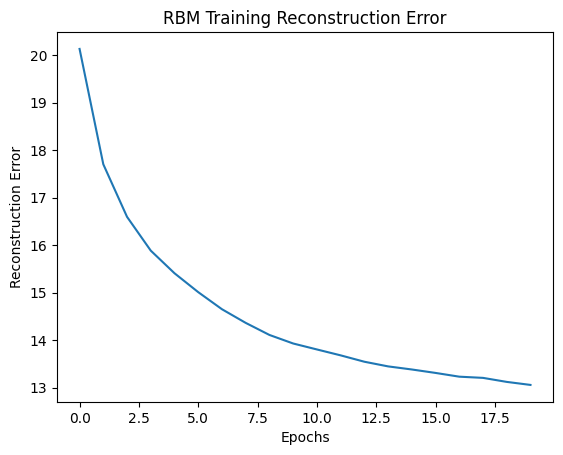

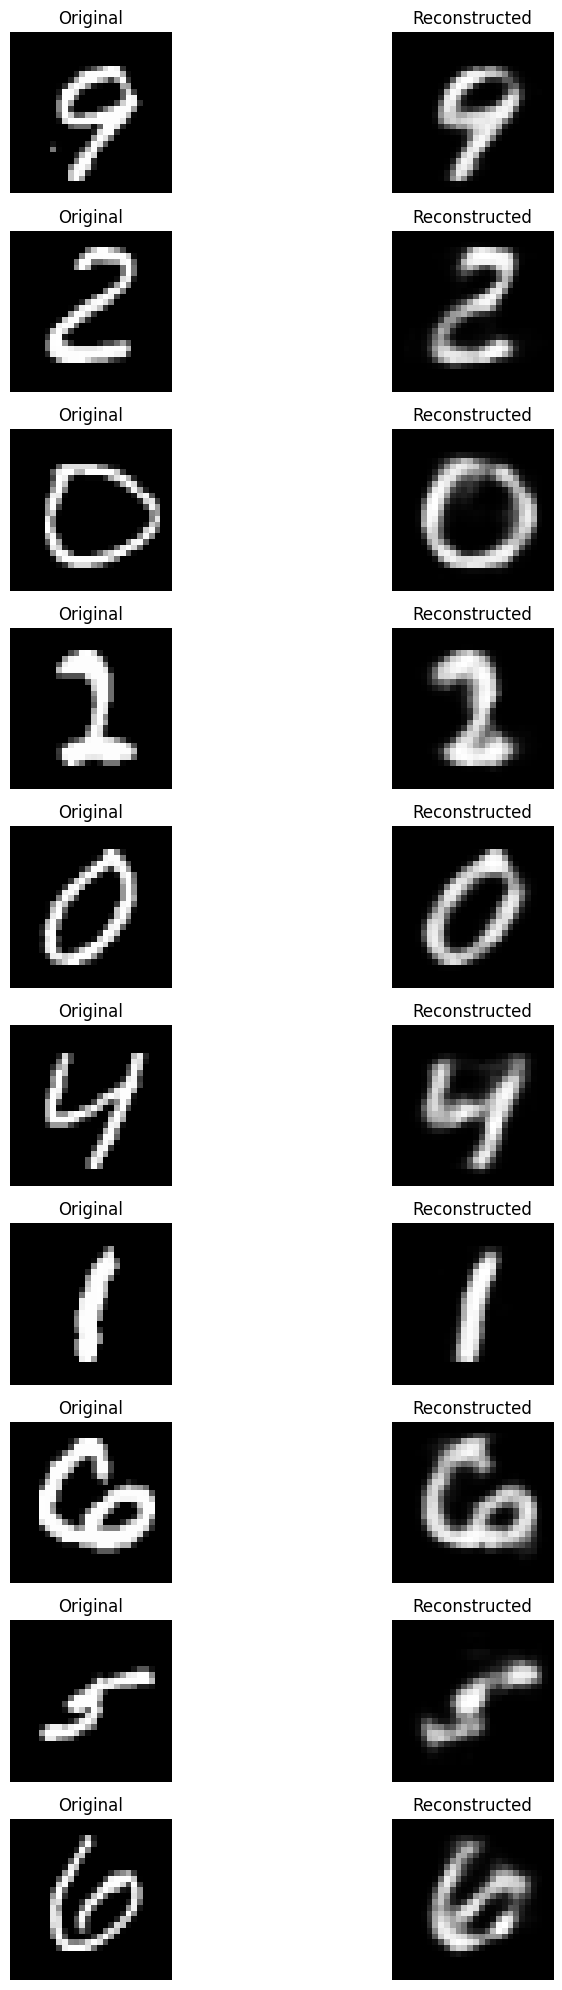

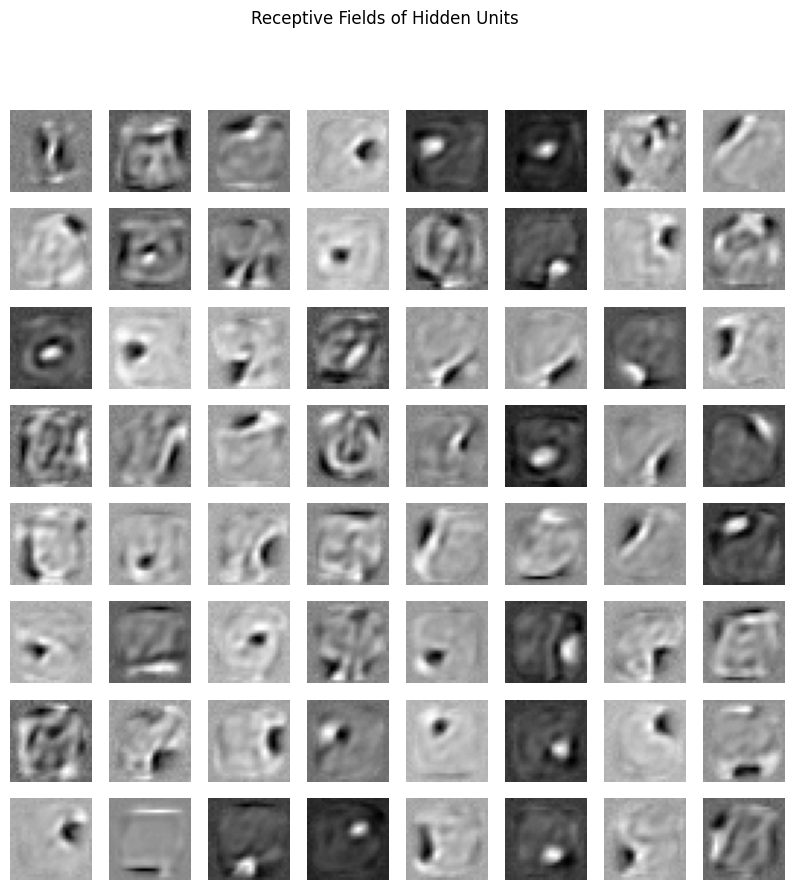

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#normalization
x_train = x_train / 255.0
x_train = x_train.reshape(-1, 784)  #convert 28x28 image to a vector

num_visible = 784
num_hidden = 64
rbm = RBM(num_visible, num_hidden)


learning_rate = 0.1
k = 1
epochs = 20
batch_size = 64
costs = rbm.train(x_train, learning_rate, k, epochs, batch_size)


plt.plot(costs)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Error')
plt.title('RBM Training Reconstruction Error')
plt.show()


n_images = 10
originals = x_train[:n_images]
reconstructions = rbm.reconstruct(originals)


fig, axes = plt.subplots(n_images, 2, figsize=(10, 20))
for i in range(n_images):
    axes[i, 0].imshow(originals[i].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructions[i].reshape(28, 28), cmap='gray')
    axes[i, 1].set_title('Reconstructed')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

rbm.plot_receptive_fields((28, 28))
